<a href="https://colab.research.google.com/github/romieuro225/Python-Machine-Learning/blob/master/Prediction_des_stocks_prices_de_Apple_avec_le_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description : Ce programme utilise un réseau neuronal artificiel récurrent appelant la mémoire à long terme (LSTM) pour prédire le cours de clôture d’une société (Apple Inc.) en utilisant le cours de l’action des 60 derniers jours.

In [1]:
!pip install tensorflow

In [2]:
!pip install pandas-datareader

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 8.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=154791ec39d55fb280c2689d8a42cebde2b6a983590d6dd250204a83c5ddedd4
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
!pip install pyfolio

     |████████████████████████████████| 91 kB 4.1 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88681 sha256=20706fd0418437edd57452e29d1300ecf42b4ef43c4b65a076c1b491948bcbf8
  Stored in directory: /root/.cache/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39777 sha256=745eb1313ba2793d41187938584e22cbbb2e922668a0392d05cacdda4ccd70d9
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [5]:
# importer mes bibliothèques
import math
import pandas as pd
import numpy as np
import seaborn as sns 
from pandas_datareader import data as pdr
import yfinance as yf
import pandas_datareader.data as web
import datetime
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import shapiro, jarque_bera, norm, linregress
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pyfolio as pf 
#from pypfopt import EfficientFrontier
#from pypfopt import risk_models
#from pypfopt import expected_returns
import statsmodels.tsa.api as tsa
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [6]:
yf.pdr_override()

In [7]:
# importer les données depuis l'API Alphavantage
df = web.get_data_yahoo('AAPL', start='2012-01-01', end='2019-12-18')

[*********************100%***********************]  1 of 1 completed


In [8]:
# Afficher les données 
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.610313,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.678086,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.818833,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.952844,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.932297,394024400
...,...,...,...,...,...,...
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.799065,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,66.969284,137310400
2019-12-13,67.864998,68.824997,67.732498,68.787498,67.879601,133587600


In [9]:
# Nombre de lignes et de colonnes dans notre dataset
print('Nombre de lignes et de colonnes:', df.shape)

Nombre de lignes et de colonnes: (2003, 6)


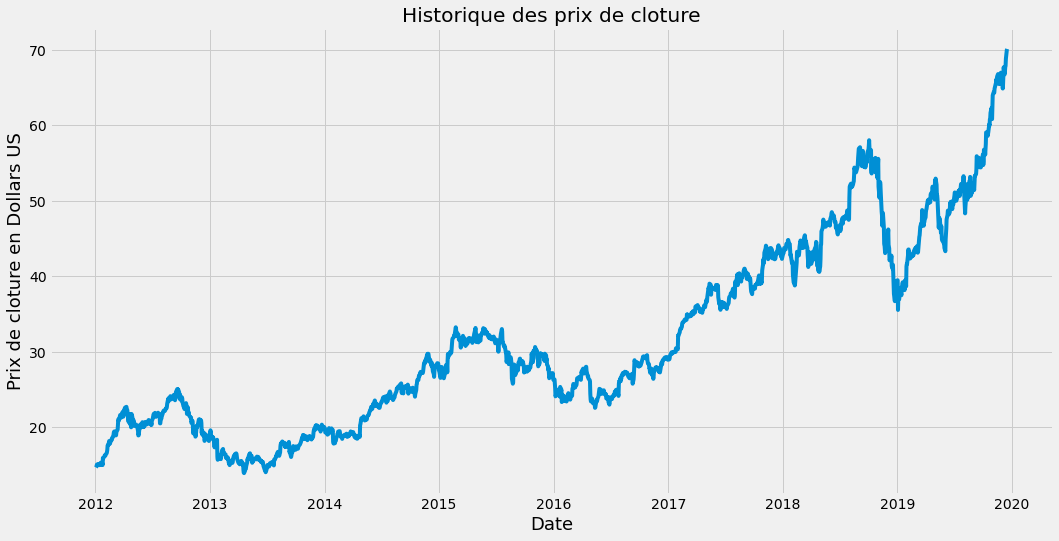

In [10]:
# Visualiser l'historique des prix de cloture de l'action Apple
plt.figure(figsize=(16,8))
plt.title('Historique des prix de cloture')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de cloture en Dollars US', fontsize=18)
plt.show()

In [11]:
# Créer une nouvelle dataframe avec la colonne 'Close'
data = df.filter(['Close'])

# Convertir la dataframe en un tableau numpy
dataset = data.values

In [12]:
# Afficher notre dataset
dataset

array([[14.6867857 ],
       [14.76571369],
       [14.92964268],
       ...,
       [68.78749847],
       [69.96499634],
       [70.10250092]])

In [13]:
# Obtenir le nombre de lignes pour l'entrainement du modèle 
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1603

In [14]:
# Normaliser les données avec la fonction MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457063],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [15]:
# Créer les données d'entrainement
# Créer les données d'entrainement normalisées
train_data = scaled_data[0:training_data_len , :]

# Diviser les données de notre dataset en x_train et y_train      
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

  if i<= 61:
    print(x_train)
    print(y_train)
    print()


[array([0.01316509, 0.01457063, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862191, 0.02173194,
       0.02453668, 0.02367172, 0.01893355, 0.02345548, 0.01900352,
       0.03569838, 0.03440732, 0.0360927 , 0.03973694, 0.04194384,
       0.0417594 , 0.0410789 , 0.04397903, 0.04670744, 0.04979839,
       0.05479095, 0.0652785 , 0.06543749, 0.07127594, 0.07563885,
       0.06814049, 0.07102789, 0.07097066, 0.07906688, 0.07791571,
       0.08004628, 0.08387497, 0.08600558, 0.09214292, 0.09661394,
       0.09790501, 0.09835659, 0.09071194, 0.08886753, 0.08914103,
       0.09632778, 0.09835024, 0.10269409, 0.11293358, 0.12659476,
       0.12403805, 0.1240444 , 0.13392141, 0.13701237, 0.13481179,
       0.13280207, 0.13070964, 0.13766105, 0.14243103, 0.14442805])]
[0.13949272033425864]

[array([0.01316509, 0.01457063, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862191, 0.02173194,
       0.02453668, 0.02367172, 0.01

In [16]:
# Convertir le x_train et y_train en tableau numpy
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# Redimensionner nos données 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
# Construire le modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
# Entrainer le modèle
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 48s 29ms/step - loss: 9.4798e-04


In [21]:
# Créer les données de test
# Créer un nouveau tableau contenant les valeurs mises à l'échelle de l'index 1543 à 2003
test_data = scaled_data[training_data_len - 60: , :]

# Créer les jeux de données x_test et y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [22]:
# Créer les données en tableau numpy
x_test = np.array(x_test)

In [23]:
# Redimensionner les données 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [24]:
# Obtenir les prix prédits par les modèles 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [25]:
# Obtenir le RMSE (Root Mean Squarred Error)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3.0286386394500733

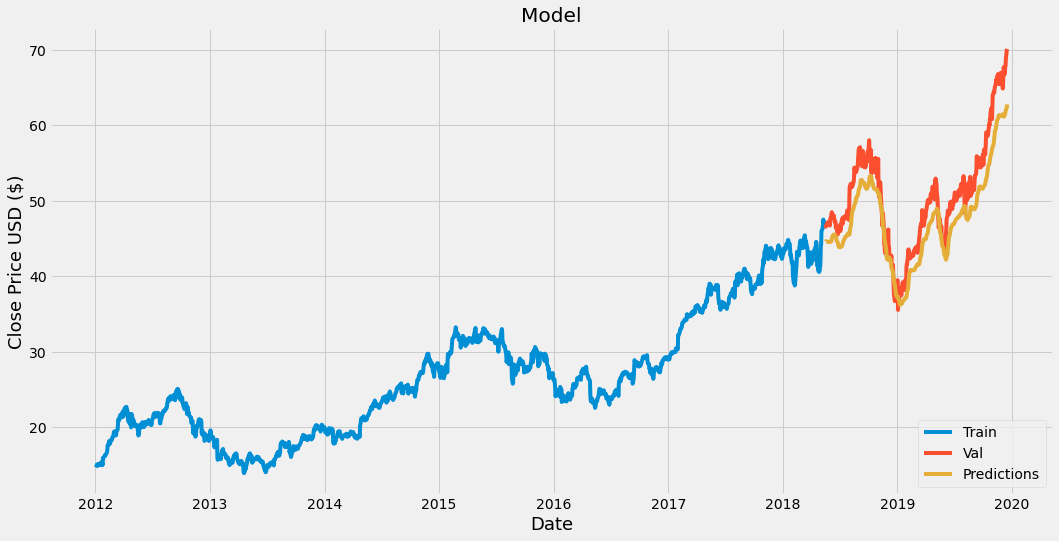

In [26]:
# Dessinons les données
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

# Visualiser les données 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()

In [27]:
# Afficher les prix de cloture de test et les prix de cloture prédits
valid

,Close,predictions
Date,,
2018-05-17,46.747501,44.607948
2018-05-18,46.577499,44.649647
2018-05-21,46.907501,44.623222
2018-05-22,46.790001,44.594028
2018-05-23,47.090000,44.554279
...,...,...
2019-12-11,67.692497,61.585453
2019-12-12,67.864998,61.795143
2019-12-13,68.787498,62.023663


In [28]:
apple_quote= web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-19')
# Créer une nouvelle dataframe
new_df= apple_quote.filter(['Close'])

# Obtenir les derniers 60 jours des prix de cloture et convertir la dataframe en array
last_60_days = new_df[-60:].values 

# Mettre à l'échelle les données entre 0 et 1
last_60_days_scaled= scaler.transform(last_60_days)

# Créer une liste vide
X_test = []

# Ajouter les 60 jours passés
X_test.append(last_60_days_scaled)

# Les convertir en numpy array
X_test = np.array(X_test)

# Redimensionner les données 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Obtenir les données prédites mises à l'échelle
pred_price = model.predict(X_test)

# Defaire le scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)





[*********************100%***********************]  1 of 1 completed
[[63.61862]]
